In [1]:
import os
import sys
import numpy as np
sys.path.append('/home/jovyan/Desktop/S4A_mod')
from model.utae import UTAE
from model.SimVP import SimVP
from model.PAD_unet import UNet
from pathlib import Path

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.plugins import DDPPlugin
import torch
from torch.nn import functional as F

from utils.PAD_datamodule import PADDataModule
from utils.tools import font_colors
from utils.settings.config import RANDOM_SEED, CROP_ENCODING, LINEAR_ENCODER, CLASS_WEIGHTS, BANDS

import matplotlib.pyplot as plt

Global seed set to 16
Global seed set to 16


In [2]:
root_dir = '/home/jovyan/shared_volume/data/newdata'
root_dir = Path(root_dir)
# Create Data Modules
dm = PADDataModule(
    root_dir=root_dir,
    scenario=2,
    band_mode='nrgb',
    linear_encoder=LINEAR_ENCODER,
    start_month=4,
    end_month=10,
    batch_size=4,
    num_workers=4,
    binary_labels=False,
    return_parcels=True,
)

dm.setup('test')

Rootdir: /home/jovyan/shared_volume/data/newdata
Scenario: 2, MODE: test, length of datasets: 1364
Acquired Data Month: From 4 to 10
Data shape: [T, C, H, W] (6, 4, 366, 366)


In [3]:
dataloader = dm.test_dataloader()

In [4]:
resume_from_checkpoint = '/home/jovyan/Desktop/S4A_mod/logs/unet/20230212160830/run_20230212160830/checkpoints/epoch=300-step=171269.ckpt'
run_path = os.path.dirname(os.path.dirname(resume_from_checkpoint))

crop_encoding_rev = {v: k for k, v in CROP_ENCODING.items()}
crop_encoding = {k: crop_encoding_rev[k] for k in LINEAR_ENCODER.keys() if k != 0}
crop_encoding[0] = 'Background/Other'

model_name = 'simp'
model = UNet.load_from_checkpoint(resume_from_checkpoint,
                                                    map_location=torch.device('cpu'),
                                                    run_path=run_path,
                                                    linear_encoder=LINEAR_ENCODER,
                                                    crop_encoding=crop_encoding,
                                                    checkpoint_epoch=300,
                                                    class_weights = {LINEAR_ENCODER[k]: v for k, v in CLASS_WEIGHTS.items()}
                                                    )
    

In [5]:
def slide_inference(img):

        h_stride, w_stride = 48, 48
        h_crop, w_crop = 64, 64
        batch_size, timestamp, channel, h_img, w_img = img.size()
        num_classes = max(LINEAR_ENCODER.values()) + 1
        h_grids = max(h_img - h_crop + h_stride - 1, 0) // h_stride + 1
        w_grids = max(w_img - w_crop + w_stride - 1, 0) // w_stride + 1
        preds = img.new_zeros((batch_size, num_classes, h_img, w_img))
        count_mat = img.new_zeros((batch_size, 1, h_img, w_img))
        #print(preds.shape)
        # img = img.view(batch_size, -1, h_img, w_img)

        for h_idx in range(h_grids):
            for w_idx in range(w_grids):
                y1 = h_idx * h_stride
                x1 = w_idx * w_stride
                y2 = min(y1 + h_crop, h_img)
                x2 = min(x1 + w_crop, w_img)
                y1 = max(y2 - h_crop, 0)
                x1 = max(x2 - w_crop, 0)
                crop_img = img[..., y1:y2, x1:x2]
                # crop_seg_logit = self.encode_decode(crop_img, img_meta)
                
                crop_seg_logit = model(crop_img).to(torch.long)  # (B, K, H, W)
                # Reverse the logarithm of the LogSoftmax activation
                crop_seg_logit = torch.exp(crop_seg_logit)
                # Clip predictions larger than the maximum possible label
                crop_seg_logit = torch.clamp(crop_seg_logit, 0, max(LINEAR_ENCODER.values()))
                #print(crop_seg_logit.shape)
                preds += F.pad(crop_seg_logit,
                               (int(x1), int(preds.shape[3] - x2), int(y1),
                                int(preds.shape[2] - y2)))
                count_mat[:, :, y1:y2, x1:x2] += 1

        assert (count_mat == 0).sum() == 0
        preds = preds / count_mat
        return preds

In [6]:
for idx, batch in enumerate(dataloader):
    img = batch['medians']
    ann = batch['labels']
    parcel = batch['parcels']

    if img.shape[3] != 64 and model_name == 'simvp':
        y = slide_inference(img)
    # print(ann.shape)
    # b, t, c, h, w = img.shape
    # x = img.view(b, -1, h, w)
    else:
        y = model(img)
    break

In [7]:
pred = torch.exp(y.to(torch.long))
pred = torch.clamp(pred, 0, max(LINEAR_ENCODER.values()))

In [8]:
pred = torch.argmax(pred, dim=1)
pred = pred.detach().cpu().numpy() # [0]

In [9]:
ann = ann.detach().cpu().numpy() # [0]
parcel = parcel.detach().cpu().numpy() # [0]

In [10]:
correct = pred == ann
incorrect = pred != ann
correct_map = np.zeros(correct.shape)
correct_map[correct] = 2
correct_map[incorrect] = 1
correct_map = correct_map * parcel

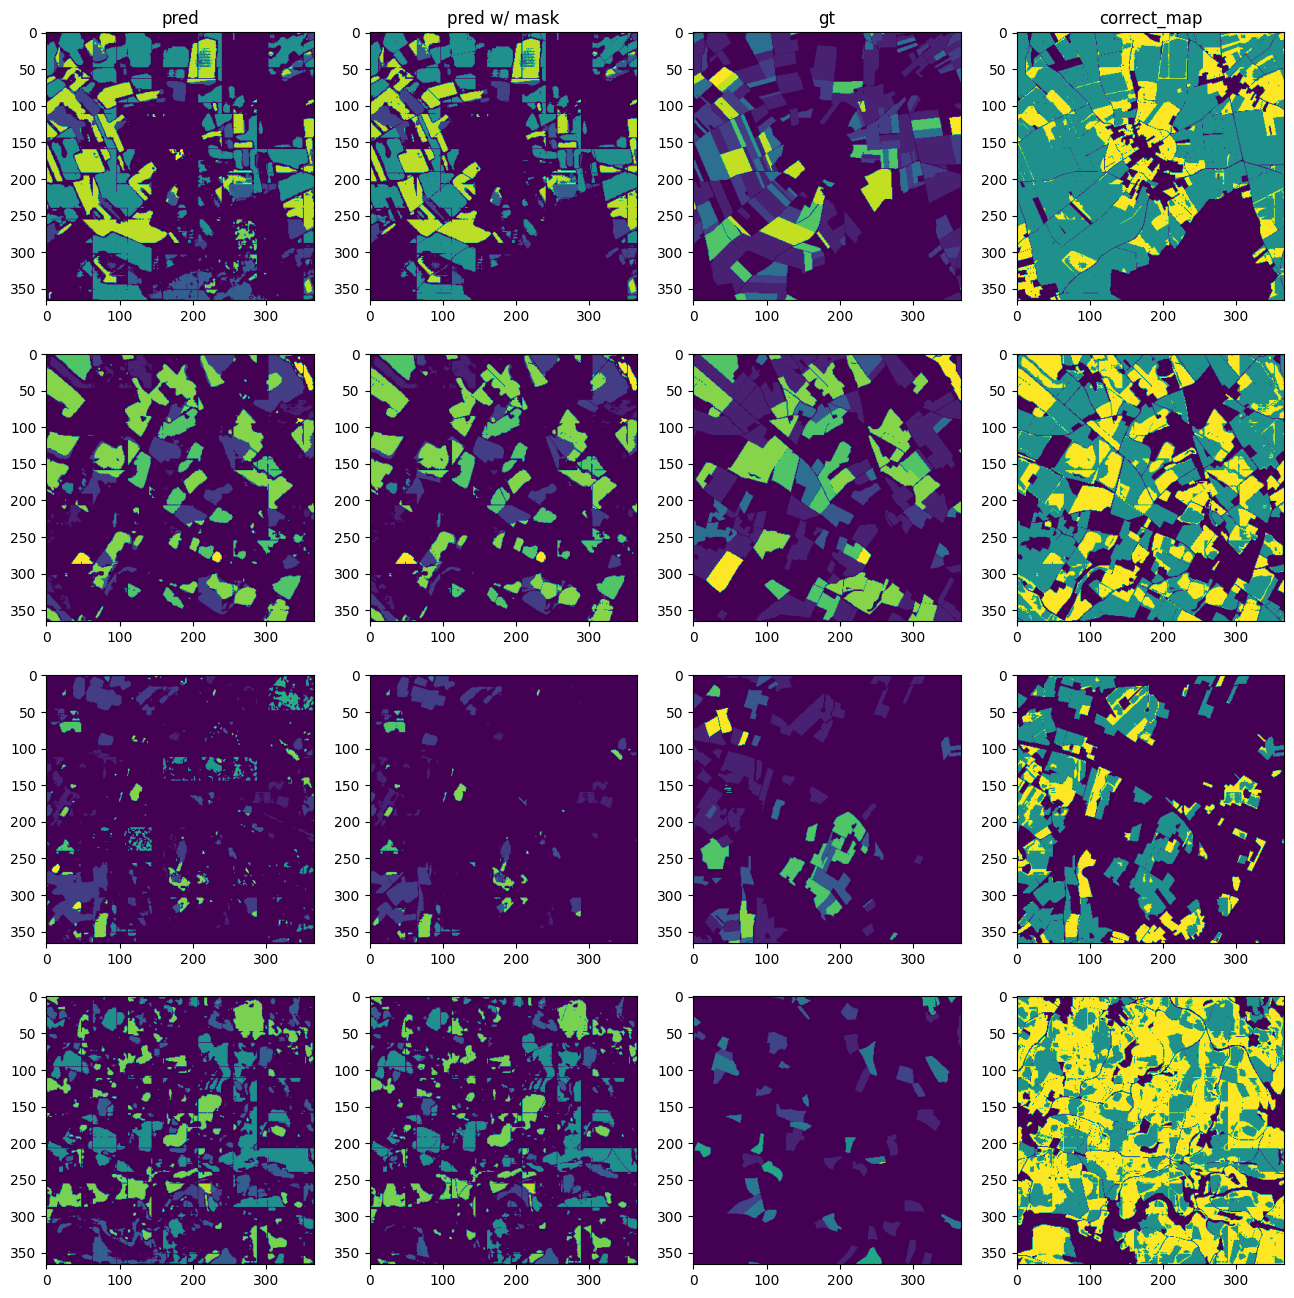

In [11]:
fig, ax = plt.subplots(4,4, figsize=(16,16))
for i in range(4):
    ax[i][0].imshow(pred[i])
    ax[i][1].imshow(pred[i] * parcel[i])
    ax[i][2].imshow(ann[i])
    ax[i][3].imshow(correct_map[i])
title = ['pred', 'pred w/ mask', 'gt', 'correct_map']
for a, t in zip(ax[0], title):
    a.set_title(t)
plt.show()